In [1]:
from google.colab import drive
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np
import os 
from os import listdir
from random import sample
import pandas as pd
import random
np.random.seed(2)
np.random.RandomState(2)
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model
import sklearn
from collections import Counter

# A Note on File Paths

The below code was written in Google Colab due to the time required to model the data. This notebook was mounted on the Google Drive, on the code file paths reflect as such. 

Similarly named files, i.e. the original images saved down in a file called 'raw_dataset' should result in the code running without issues.

If any guidance is required, users are encouraged to reach out via Github.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Read in the image datasets.

In [ ]:
data_path = '/content/drive/MyDrive/clothing_class/raw_dataset'
imseg_data_path_kmeans = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans'
imseg_data_path_kmeans3 = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans3'
imseg_data_path_contour = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_contour'
imseg_data_path_thresh = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_thresholding'

Setting up a list of the file names inside the image folder.

In [ ]:
data_files = os.listdir(data_path)

## Read in CSV Files

Full and resampled (downsampled solids) dataset read in below.

In [3]:
clothes_df = pd.read_csv('/content/drive/MyDrive/clothing_class/dataset.csv')
resampled_df = pd.read_csv('/content/drive/MyDrive/clothing_class/data_resampled.csv')

## Image Data Generator

A series of image augmentations were added to enhance performance. The training images are rescaled, flipped vertically/horizontally, rotated up to 40 degrees, shifted in width, height, slant, and zoom. This aims to provide the model with additional versions of the image, and more data, on which to train.

The test set is rescaled.

The dataset is split 80% to training, 20% to validation.

In [4]:
aug_train_gen = ImageDataGenerator(
    rescale = 1/255,
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split=0.2,
)

Creating a training generator that only flips horizontally and rotates the images.

In [5]:
la_train_gen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    rotation_range = 40,
    validation_split=0.2,
)

## Generate Image Tensor Data

The function below generates the tensor data that will be used for modeling.

The function can be used for both training and testing sets, both garment and pattern modeling via the y-col argument, and reads in a specified dataset so that any of the segmented datasets can be selected.

In [ ]:
def tensor_data(image_gen,data_frame,image_data_path,y_column,subset):
  tensor_data = image_gen.flow_from_dataframe(
  dataframe=data_frame,
  directory=image_data_path,
  x_col="file_name",
  y_col=y_column,
  batch_size=32,
  shuffle=False,
  color_mode='rgb',
  class_mode="categorical",
  subset=subset,
  random_state=2,
  seed=2,
  target_size=(224,224),
  validate_filenames=False)

  return tensor_data

## Early Stop

Initializing an early stop regularization that will monitor increases in val loss metric.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           verbose=0,
                          )

## Checkpoint

This checkpoint feature will save down the best performing epoch, based on validation accuracy, that will provide a model on which predictions and evaluations can be performed.

In [ ]:
def checkpoint(cp_name):
  return ModelCheckpoint(
                             monitor='val_accuracy', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto',
                             filepath ='/content/drive/MyDrive/clothing_class/model_folder/'+str(cp_name)
                             )

## Model Functions

I elected to proceed with showcasing the transfer learning modeling using VGG16 alone for this stage.

The below function allows for the Dense layer units to be specified, as well as for an Adam learning rate to be specified. Generally a learning rate of .01 was used when modeling with VGG16 transfer learning during this stage of analysis.

In addition to the layers inherent to the VGG architecture, additional Dense, Batch normalization, and dropout layers were addded. This particular architecture seemed to generate the best scores accross the various image sets.

In [ ]:
def model_function(classes,alr):
  
    base_model = VGG16(include_top=False,
                     input_shape=(224, 224, 3),
                     weights='imagenet'
                     )
    for layer in base_model.layers:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        
        base_model,
        
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),

        tf.keras.layers.Dense(units=classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=alr),
        metrics=['accuracy']
    )
    
    return model

To observe the impact of transfer learning, an additional function was set up with a similar structure to the above VGG model, without the transfer learning.

In [ ]:
def seq_model_function(classes,alr):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu',
                 padding='same',input_shape=(224,224,3)))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))

  model.add(Dense(units=classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',metrics="accuracy",optimizer=Adam(learning_rate=alr))

  return model

## Plot Functions

A function was built to plot the accuracy and validation accuracy at each epoch. The plot is displayed and saved down to a seperate folder.

In [ ]:
def plot_accuracy(history,title,ext):
  plt.figure(figsize=(20,10))
  plt.plot(history.history['accuracy'], label='Train')
  plt.plot(history.history['val_accuracy'], label='Test')
  plt.ylabel('Accuracy',fontsize=20)
  plt.xlabel('Epochs',fontsize=20)
  plt.legend(prop={'size': 20})
  plt.title(title,fontsize=20)
  plt.savefig('/content/drive/MyDrive/clothing_class/jpegs/'+str(ext)+'_acc.jpeg',format='jpeg',bbox_inches='tight');

A function was built to plot the confusion matrix for each model, using the model predictions and the ground truths for the test set. The matrix is displayed and saved down to a seperate folder.

In [ ]:
def plot_confusion_matrix(checkpoint,test_data,title,ext):
  preds = load_model('/content/drive/MyDrive/clothing_class/model_folder/'+checkpoint).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  fig,ax = plt.subplots(figsize=(20,10))
  ConfusionMatrixDisplay.from_predictions(label_true,
                                        predictions,cmap='Blues',
                                        ax=ax,
                                        )
  ax.set_xlabel('Predicted Label',fontsize=15)
  ax.set_ylabel('True Label',fontsize=15)
  plt.title(title,fontsize=20)
  plt.show()
  fig.savefig('/content/drive/MyDrive/clothing_class/jpegs/'+str(ext)+'_cm.jpeg',format='jpeg',bbox_inches='tight');

## Function for Calculating Balanced Accuracy

A function was created to calculate the balanced accuracy for a given model and dataset.

In [ ]:
def calculate_balanced_acc(model,dataframe,image_file,y_col):
  
  test_data = tensor_data(test_gen,dataframe,image_file,
                   y_col,'validation')
  
  preds = load_model('/content/drive/MyDrive/clothing_class/model_folder/'+model).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  return sklearn.metrics.balanced_accuracy_score(label_true,predictions)

## Baselines

Reviewing the baseline values for these datasets to determine the accuracy level that must be surpassed to determine that a model performs better than merely choosing the majority class every time.

In [6]:
clothes_df['garment_label'].value_counts(normalize=True)

dress      0.139226
sweater    0.136002
coat       0.134484
pants      0.129932
tshirt     0.116654
top        0.107360
jacket     0.087253
shorts     0.086495
skirt      0.062595
Name: garment_label, dtype: float64

The garment baseline for the dataset is ~14%.

In [7]:
clothes_df['pattern_label'].value_counts(normalize=True)

solid        0.567527
horiz        0.161798
polka        0.091426
vertical     0.040971
chevron      0.039264
checkered    0.039264
animal       0.036039
paisley      0.023710
Name: pattern_label, dtype: float64

The pattern baseline for the whole dataset is 56.7%.

In [8]:
resampled_df['pattern_label'].value_counts(normalize=True)

horiz        0.296386
solid        0.207783
polka        0.167477
vertical     0.075052
chevron      0.071925
checkered    0.071925
animal       0.066018
paisley      0.043433
Name: pattern_label, dtype: float64

The pattern baseline for the resampled dataset (which downsamples solid patterns) is ~30%. The resampled dataset will only be used for pattern modeling.

# Modeling 

The below modeling aims to identify the augmentation/segmentation that generates the best accuracy when attempting to classify type of garment/garment pattern within an image.

It should be noted that the test sets are segmented as well (but not augmented). If a certain kind of segmentation especially lends itself to classifying type of garment or pattern, we would consider segmenting future 'new' images as they are received and prepared to be classified.

## Transfer Learning Pattern Model - KMeans (K=5)

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
Epoch 1/50
132/132 [==============================] - 72s 522ms/step - loss: 1.1350 - accuracy: 0.6655 - val_loss: 0.9108 - val_accuracy: 0.7258
Epoch 2/50
132/132 [==============================] - 69s 522ms/step - loss: 0.8930 - accuracy: 0.7357 - val_loss: 0.7358 - val_accuracy: 0.7742
Epoch 3/50
132/132 [==============================] - 69s 520ms/step - loss: 0.8042 - accuracy: 0.7565 - val_loss: 0.6407 - val_accuracy: 0.8178
Epoch 4/50
132/132 [==============================] - 70s 532ms/step - loss: 0.7486 - accuracy: 0.7715 - val_loss: 0.5605 - val_accuracy: 0.8302
Epoch 5/50
132/132 [==============================] - 69s 526ms/step - loss: 0.7164 - accuracy: 0.7862 - val_loss: 0.4917 - val_accuracy: 0.8586
Epoch 6/50
132/132 [==============================] - 64s 484ms/step - loss: 0.7023 - accuracy: 0.7945 - val_loss: 0.5719 - val_accuracy: 0.8368


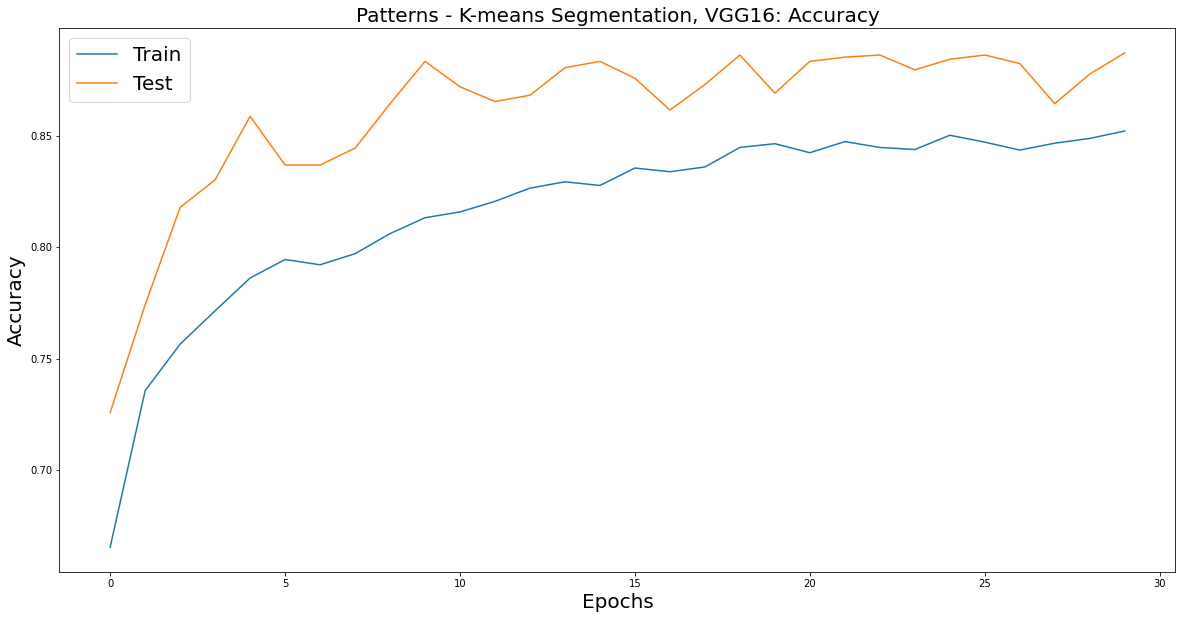

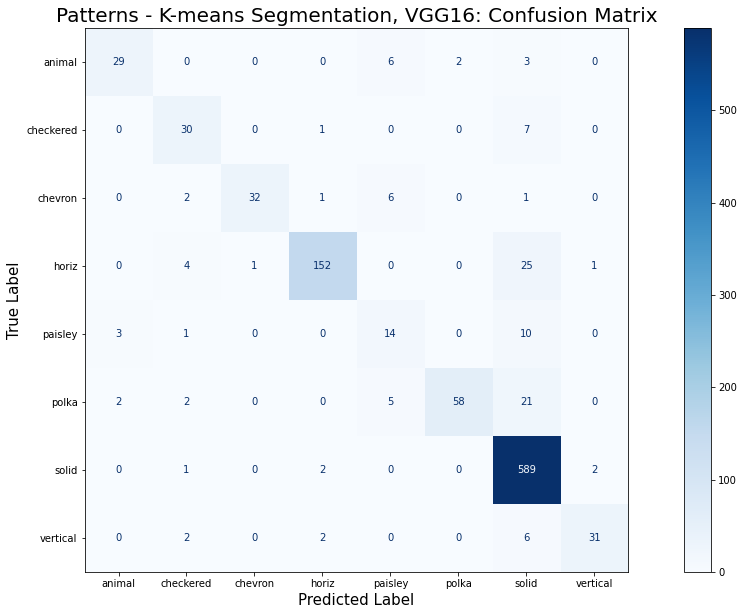

In [ ]:
model_vp_kmeans = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans = checkpoint('model_vp_kmeans')

history_vp_kmeans = model_vp_kmeans.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans,'Patterns - K-means Segmentation, VGG16: Accuracy',
              'kmeans_pattern_transfer')

plot_confusion_matrix('model_vp_kmeans',test_data,
                      'Patterns - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_pattern_transfer')

The transfer learning model using K-Means segmented images scored fairly strongly on the pattern dataset, achieving a validation accuracy of 88.71%.

The areas of notable misclassification are horizontal, polkadot and paisley print being misclassified as solids.

In [ ]:
calculate_balanced_acc('model_vp_kmeans',clothes_df,imseg_data_path_kmeans,'pattern_label')

Found 1054 non-validated image filenames belonging to 8 classes.


0.7517188125825591

Due to the dataset's imbalance, the balanced accuracy on the testing set fell to 75.17%.

## Transfer Learning Model, K-Means (K=5) - Resampled Pattern Data

Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
Epoch 1/50
72/72 [==============================] - 44s 588ms/step - loss: 1.5926 - accuracy: 0.4347 - val_loss: 1.3446 - val_accuracy: 0.4870
Epoch 2/50
72/72 [==============================] - 40s 558ms/step - loss: 1.1967 - accuracy: 0.5997 - val_loss: 1.2318 - val_accuracy: 0.5600
Epoch 3/50
72/72 [==============================] - 40s 553ms/step - loss: 1.0554 - accuracy: 0.6513 - val_loss: 0.8372 - val_accuracy: 0.7357
Epoch 4/50
72/72 [==============================] - 35s 478ms/step - loss: 0.9665 - accuracy: 0.6952 - val_loss: 0.9837 - val_accuracy: 0.7165
Epoch 5/50
72/72 [==============================] - 39s 548ms/step - loss: 0.9279 - accuracy: 0.7230 - val_loss: 0.8235 - val_accuracy: 0.7461
Epoch 6/50
72/72 [==============================] - 40s 552ms/step - loss: 0.9227 - accuracy: 0.7117 - val_loss: 0.7513 - val_accuracy: 0.7617
Epoch 7/50
72

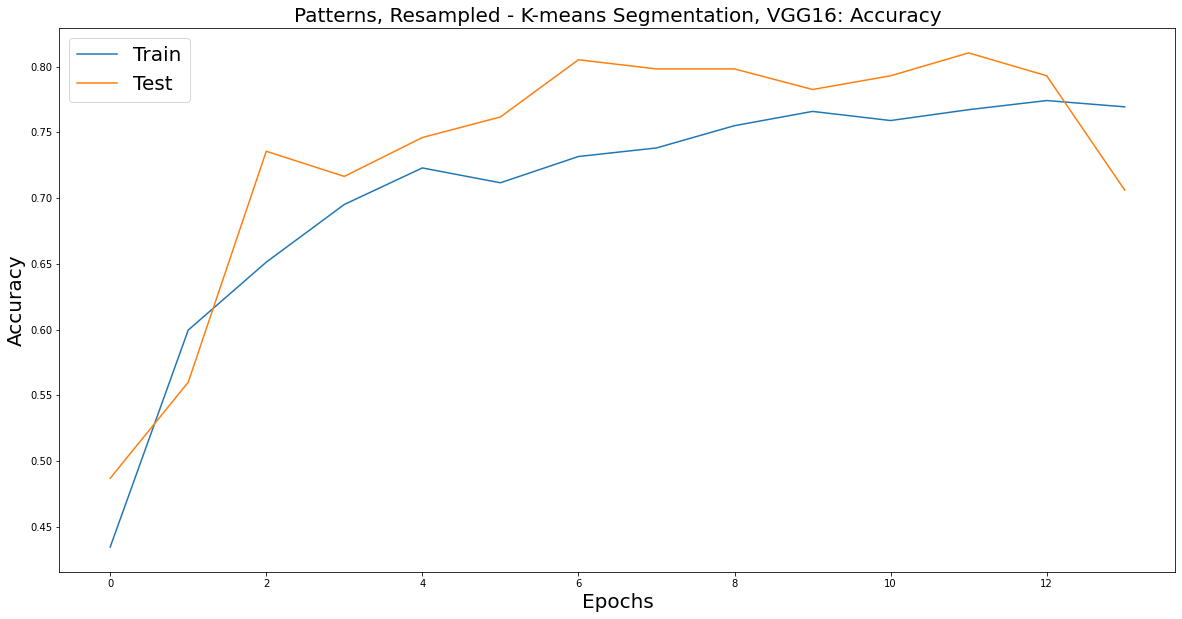

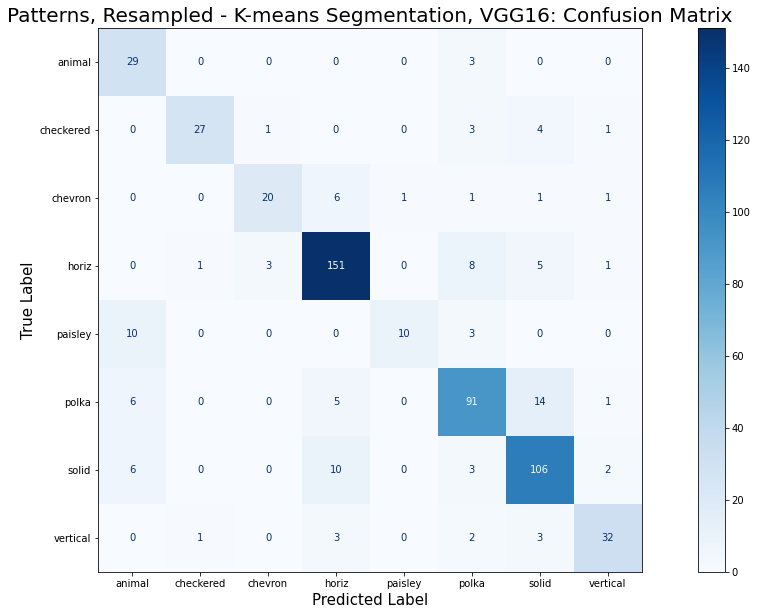

In [ ]:
model_vp_kmeans_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,imseg_data_path_kmeans,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,imseg_data_path_kmeans,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans_r = checkpoint('model_vp_kmeans_r')

history_vp_kmeans_r = model_vp_kmeans_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans_r,'Patterns, Resampled - K-means Segmentation, VGG16: Accuracy',
              'kmeans_pattern_transfer_r')

plot_confusion_matrix('model_vp_kmeans_r',test_data,
                      'Patterns, Resampled - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_pattern_transfer_r')

When reviewing the validation accuracy score of a model fed K-Means images on the dataset that drastically downsampled solids, accuracy fell relative to the less balanced dataset.

A misclassification pattern similar to the K-means misclassifications for the complete dataset developed on the more imbalanced data.

In [ ]:
calculate_balanced_acc('model_vp_kmeans_r',resampled_df,imseg_data_path_kmeans,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7555127064462299

## Transfer Learning Garment Model - KMeans (K =5)

58900480/58889256 [==============================] - 0s 0us/step
Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 1492s 11s/step - loss: 2.0031 - accuracy: 0.2655 - val_loss: 2.3942 - val_accuracy: 0.1879
Epoch 2/50
132/132 [==============================] - 63s 474ms/step - loss: 1.7513 - accuracy: 0.3687 - val_loss: 1.7768 - val_accuracy: 0.3378
Epoch 3/50
132/132 [==============================] - 64s 489ms/step - loss: 1.6323 - accuracy: 0.4113 - val_loss: 1.4622 - val_accuracy: 0.4639
Epoch 4/50
132/132 [==============================] - 63s 475ms/step - loss: 1.5469 - accuracy: 0.4386 - val_loss: 1.2710 - val_accuracy: 0.5342
Epoch 5/50
132/132 [==============================] - 63s 475ms/step - loss: 1.5014 - accuracy: 0.4666 - val_loss: 1.1960 - val_accuracy: 0.5835
Epoch 6/50
132/132 [==============================] - 58s 436ms/step - loss: 1.4

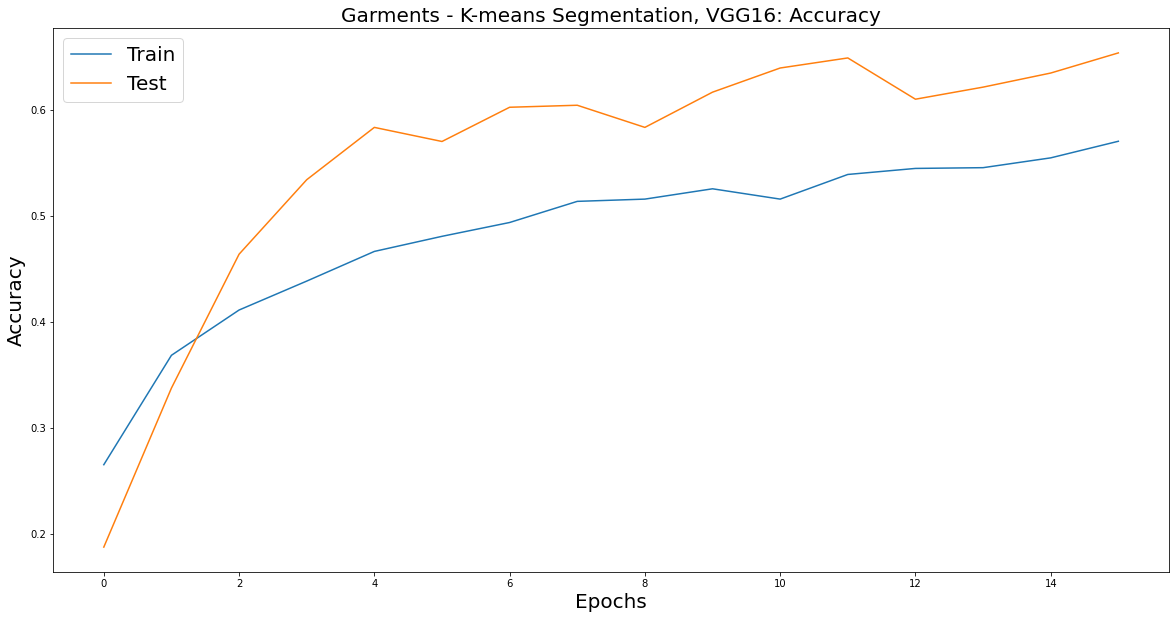

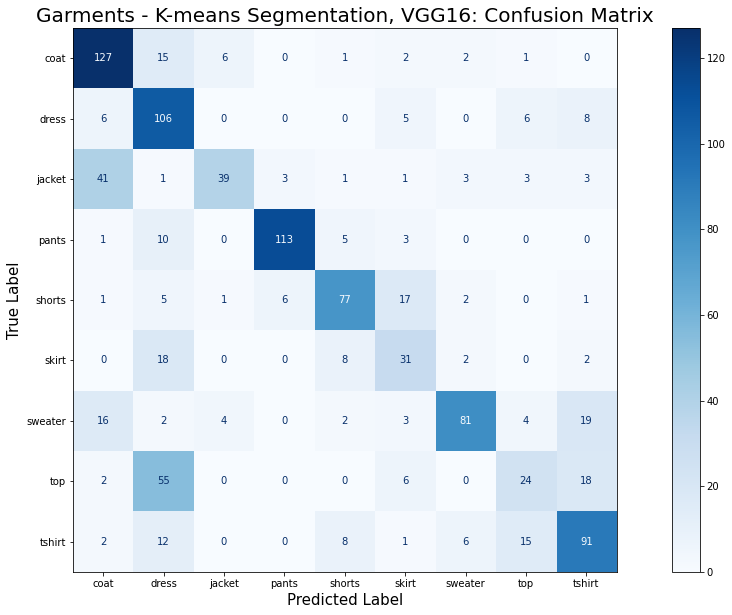

In [ ]:
model_vg_kmeans = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans,
                  'garment_label','validation')

checkpoint_model_vg_kmeans = checkpoint('model_vg_kmeans')

history_vg_kmeans = model_vg_kmeans.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_kmeans,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_kmeans,'Garments - K-means Segmentation, VGG16: Accuracy',
              'kmeans_garment_transfer')

plot_confusion_matrix('model_vg_kmeans',test_data,
                      'Garments - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_garment_transfer')

In [ ]:
calculate_balanced_acc('model_vg_kmeans',clothes_df,imseg_data_path_kmeans,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.6255094873903241

The type of garment is harder to identify in the images than pattern. 

The transfer learning model, when fed images segmented via 5 K-Means clusters, classified garments with a peak validation accuracy of 65.37%, and a balanced accuracy score of 62.5%.

Notable misclassifications are what might be expected, given the similarity in the nature of the items:
* Coats and jackets
* Tops/T-Shirts/Sweaters
* Dresses and Skirts

## Transfer Learning Model, K-Means (K=3) - Resampled Pattern Data

Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
Epoch 1/50
72/72 [==============================] - 49s 650ms/step - loss: 1.6244 - accuracy: 0.4355 - val_loss: 1.3990 - val_accuracy: 0.5426
Epoch 2/50
72/72 [==============================] - 57s 790ms/step - loss: 1.2938 - accuracy: 0.5662 - val_loss: 1.2196 - val_accuracy: 0.6174
Epoch 3/50
72/72 [==============================] - 38s 534ms/step - loss: 1.1506 - accuracy: 0.6092 - val_loss: 1.3715 - val_accuracy: 0.5791
Epoch 4/50
72/72 [==============================] - 41s 567ms/step - loss: 1.0917 - accuracy: 0.6235 - val_loss: 1.0878 - val_accuracy: 0.6626
Epoch 5/50
72/72 [==============================] - 37s 518ms/step - loss: 1.0480 - accuracy: 0.6535 - val_loss: 0.9356 - val_accuracy: 0.6678
Epoch 6/50
72/72 [==============================] - 39s 538ms/step - loss: 1.0369 - accuracy: 0.6522 - val_loss: 0.9472 - val_accuracy: 0.7270
Epoch 7/50
72

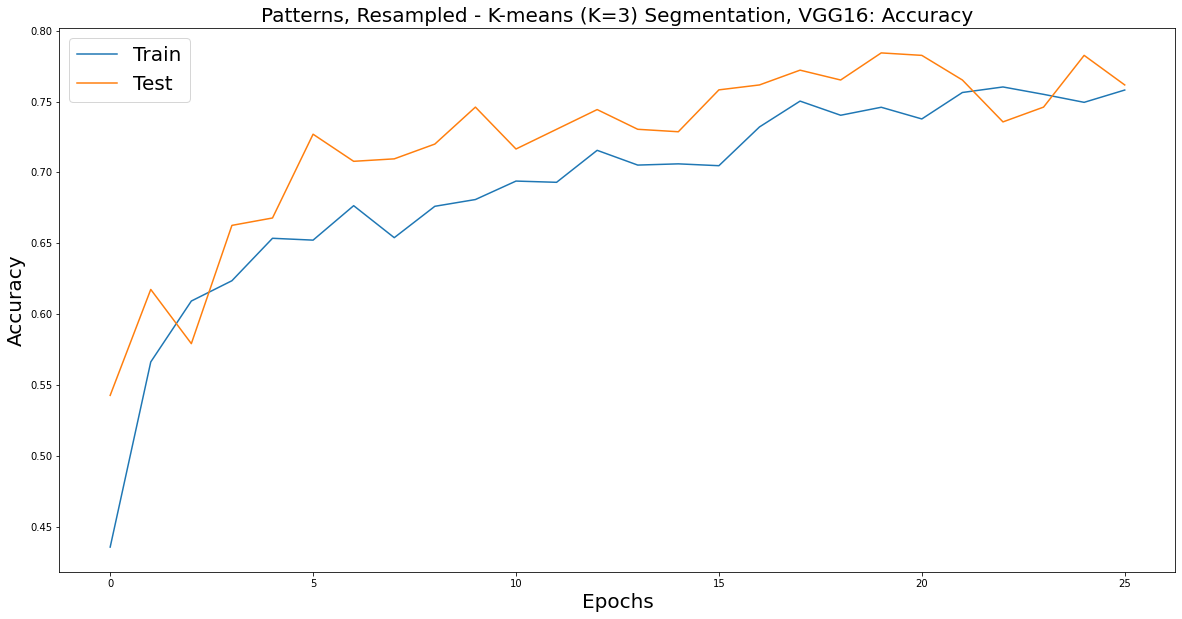

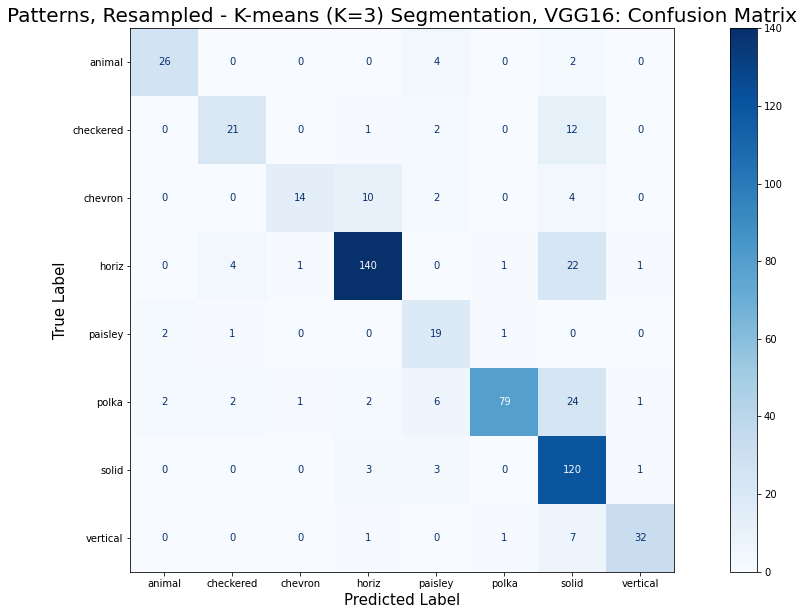

In [ ]:
model_vp_kmeans3_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,imseg_data_path_kmeans3,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,imseg_data_path_kmeans3,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans3_r = checkpoint('model_vp_kmeans3_r')

history_vp_kmeans3_r = model_vp_kmeans3_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans3_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans3_r,'Patterns, Resampled - K-means (K=3) Segmentation, VGG16: Accuracy',
              'kmeans3_pattern_transfer_r')

plot_confusion_matrix('model_vp_kmeans3_r',test_data,
                      'Patterns, Resampled - K-means (K=3) Segmentation, VGG16: Confusion Matrix',
                      'kmeans3_pattern_transfer_r')

To see if reducing the number of clusters K-Means uses to segment the image might affect the accuracy, the same model was run on the images segmented using only 3 clusters.

As might be expected when the image is segmented using fewer shading clusters, the model more often misclassifies striped (horizontal and chevron) and checkered patterns as solids because it is less proficient at distinguishing between the lines of stripe. 

In [ ]:
calculate_balanced_acc('model_vp_kmeans3_r',resampled_df,imseg_data_path_kmeans3,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7396965866551435

Ultimately, using fewer clusters in the K-Means segmentation negatively affected the balanced accuracy score, relative to the models fed images processed with 5 clusters.

## Transfer Learning - Garment Model, K-Means (K=3) Segmentation

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 67s 490ms/step - loss: 2.0083 - accuracy: 0.2541 - val_loss: 2.0253 - val_accuracy: 0.2875
Epoch 2/50
132/132 [==============================] - 62s 473ms/step - loss: 1.7864 - accuracy: 0.3483 - val_loss: 1.8542 - val_accuracy: 0.3112
Epoch 3/50
132/132 [==============================] - 62s 470ms/step - loss: 1.6990 - accuracy: 0.3762 - val_loss: 1.4524 - val_accuracy: 0.4146
Epoch 4/50
132/132 [==============================] - 57s 434ms/step - loss: 1.6350 - accuracy: 0.4016 - val_loss: 1.6369 - val_accuracy: 0.4137
Epoch 5/50
132/132 [==============================] - 63s 475ms/step - loss: 1.6051 - accuracy: 0.4263 - val_loss: 1.3642 - val_accuracy: 0.4782
Epoch 6/50
132/132 [==============================] - 64s 484ms/step - loss: 1.5575 - accuracy: 0.4414 - val_loss: 1.3355 - val_accuracy: 0.5285


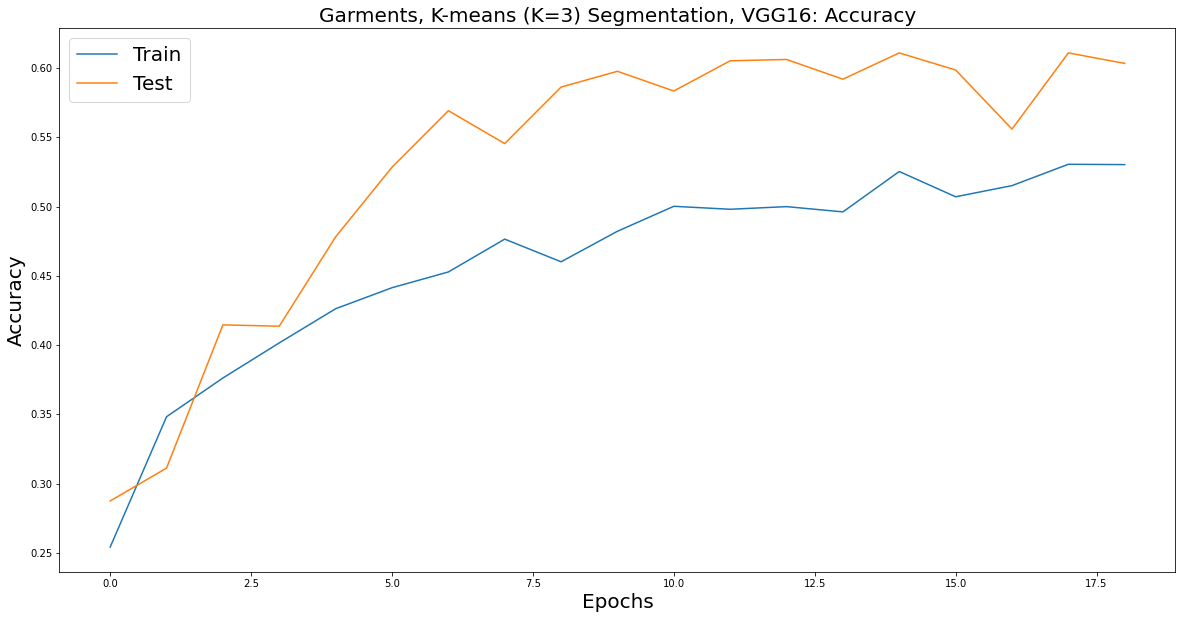

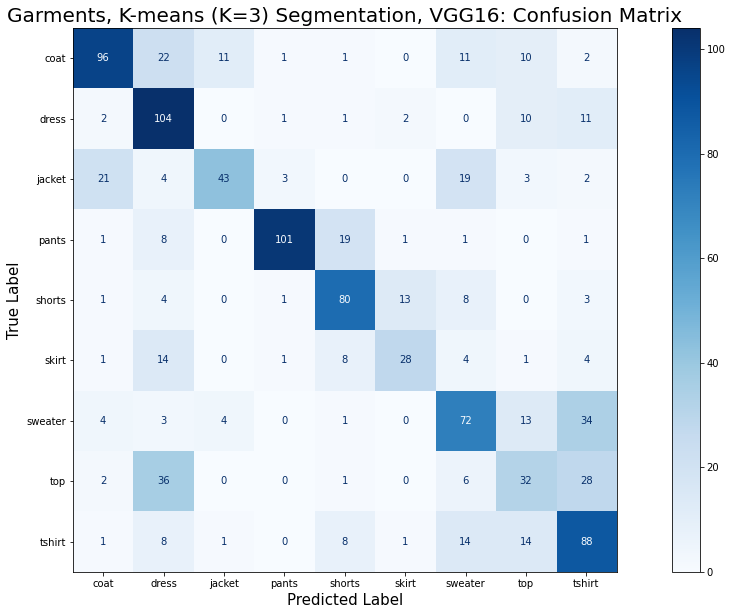

In [ ]:
model_vg_kmeans3 = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans3,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans3,
                  'garment_label','validation')

checkpoint_model_vg_kmeans3 = checkpoint('model_vg_kmeans3')

history_vg_kmeans3 = model_vg_kmeans3.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_kmeans3,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_kmeans3,'Garments, K-means (K=3) Segmentation, VGG16: Accuracy',
              'kmeans3_garment_transfer')

plot_confusion_matrix('model_vg_kmeans3',test_data,
                      'Garments, K-means (K=3) Segmentation, VGG16: Confusion Matrix',
                      'kmeans3_garment_transfer')

When using 3 clusters to segment the image via K-Means, the model classifying garments performed worse than the model fed data segmented with five clusters, with similar misclassifications.

## Sequential Pattern Model - Contour

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
Epoch 1/50
132/132 [==============================] - 78s 579ms/step - loss: 1.4665 - accuracy: 0.5576 - val_loss: 1.4386 - val_accuracy: 0.5636
Epoch 2/50
132/132 [==============================] - 62s 471ms/step - loss: 1.2582 - accuracy: 0.6238 - val_loss: 1.1386 - val_accuracy: 0.6755
Epoch 3/50
132/132 [==============================] - 56s 427ms/step - loss: 1.2015 - accuracy: 0.6437 - val_loss: 1.1392 - val_accuracy: 0.6689
Epoch 4/50
132/132 [==============================] - 58s 439ms/step - loss: 1.1749 - accuracy: 0.6522 - val_loss: 1.1357 - val_accuracy: 0.6822
Epoch 5/50
132/132 [==============================] - 58s 441ms/step - loss: 1.1505 - accuracy: 0.6543 - val_loss: 1.0747 - val_accuracy: 0.7002
Epoch 6/50
132/132 [==============================] - 61s 466ms/step - loss: 1.1376 - accuracy: 0.6629 - val_loss: 1.0992 - val_accuracy: 0.6822


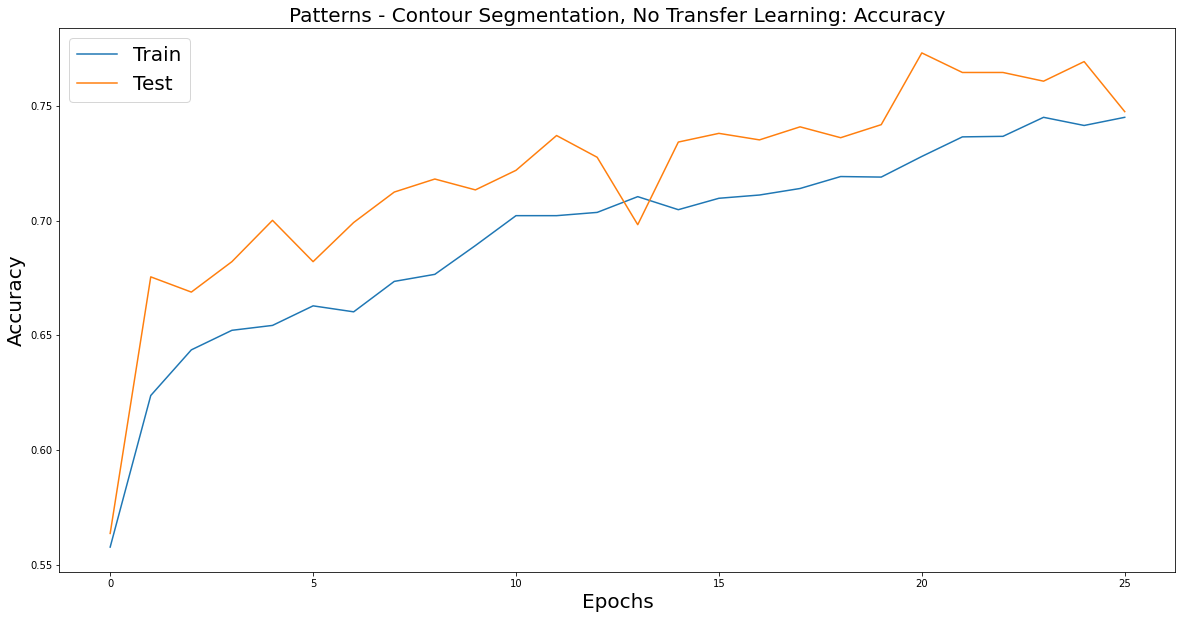

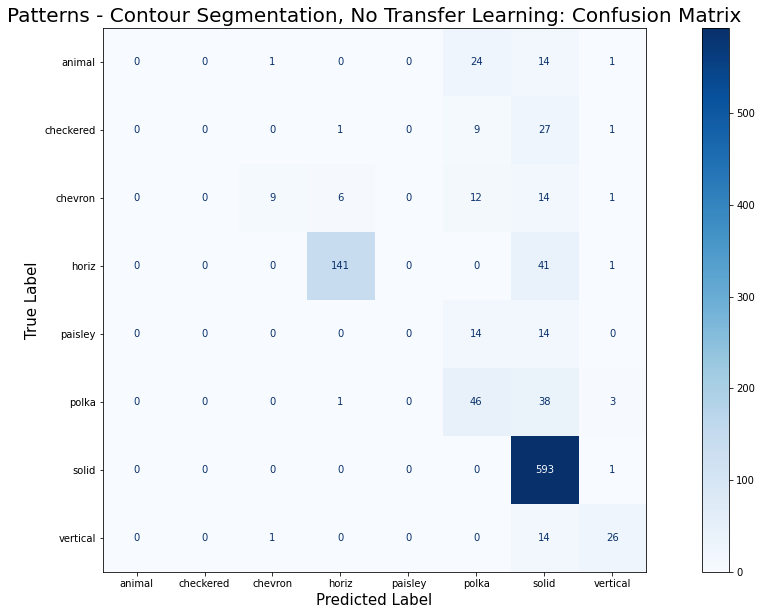

In [ ]:
model_sp_contour = seq_model_function(classes = 8,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_contour,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_contour,
                  'pattern_label','validation')

checkpoint_model_sp_contour = checkpoint('model_sp_contour')

history_sp_contour = model_sp_contour.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_sp_contour,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sp_contour,'Patterns - Contour Segmentation, No Transfer Learning: Accuracy',
              'contour_pattern_cnn')

plot_confusion_matrix('model_sp_contour',test_data,
                      'Patterns - Contour Segmentation, No Transfer Learning: Confusion Matrix',
                      'contour_pattern_cnn')

The models that did not utilize transfer learning performed better for the contour segmented images than the models that used transfer learning. With its highest validation accuracy level at ~77%, the contour model performs considerably worse than K-Means model.

Notable misclassifications again include paisley, polka and horizontal stripes but animal print, checkered and chevron striped misclassifications also become more common than in the K-Means model.

## Transfer Learning Garment Model - Contour

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 1202s 9s/step - loss: 2.1031 - accuracy: 0.2051 - val_loss: 2.1545 - val_accuracy: 0.1641
Epoch 2/50
132/132 [==============================] - 66s 499ms/step - loss: 1.9711 - accuracy: 0.2788 - val_loss: 1.9284 - val_accuracy: 0.3292
Epoch 3/50
132/132 [==============================] - 64s 488ms/step - loss: 1.8927 - accuracy: 0.3151 - val_loss: 1.7812 - val_accuracy: 0.3321
Epoch 4/50
132/132 [==============================] - 65s 490ms/step - loss: 1.8316 - accuracy: 0.3490 - val_loss: 1.8081 - val_accuracy: 0.3558
Epoch 5/50
132/132 [==============================] - 66s 498ms/step - loss: 1.7991 - accuracy: 0.3592 - val_loss: 1.8818 - val_accuracy: 0.3672
Epoch 6/50
132/132 [==============================] - 64s 488ms/step - loss: 1.7515 - accuracy: 0.3713 - val_loss: 1.5779 - val_accuracy: 0.4630
E

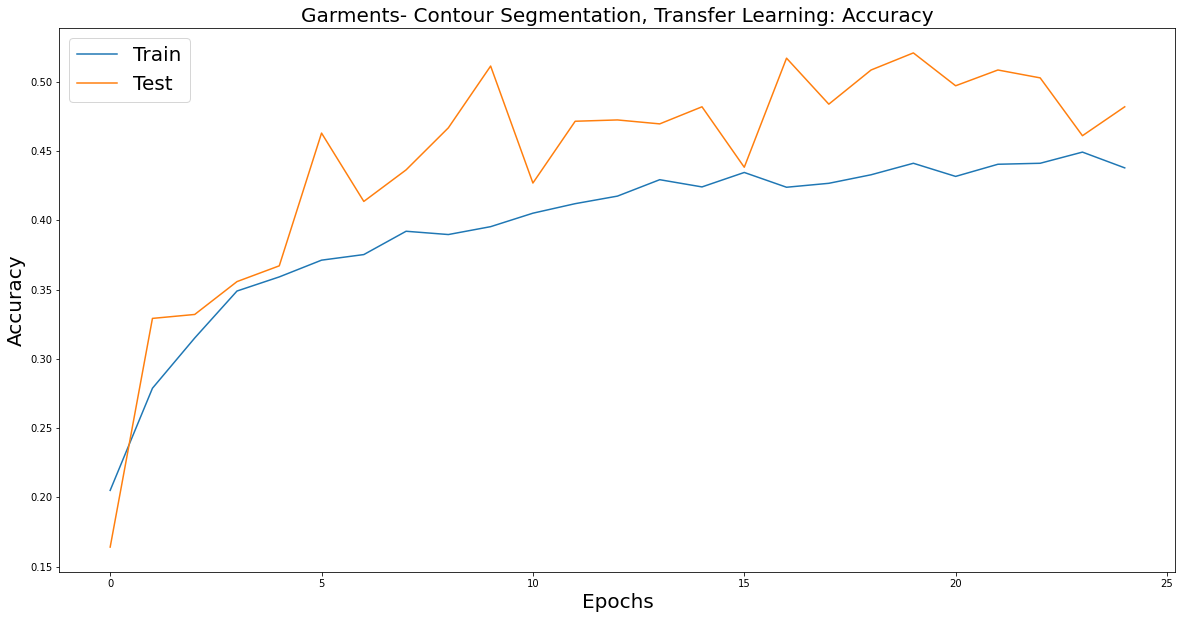

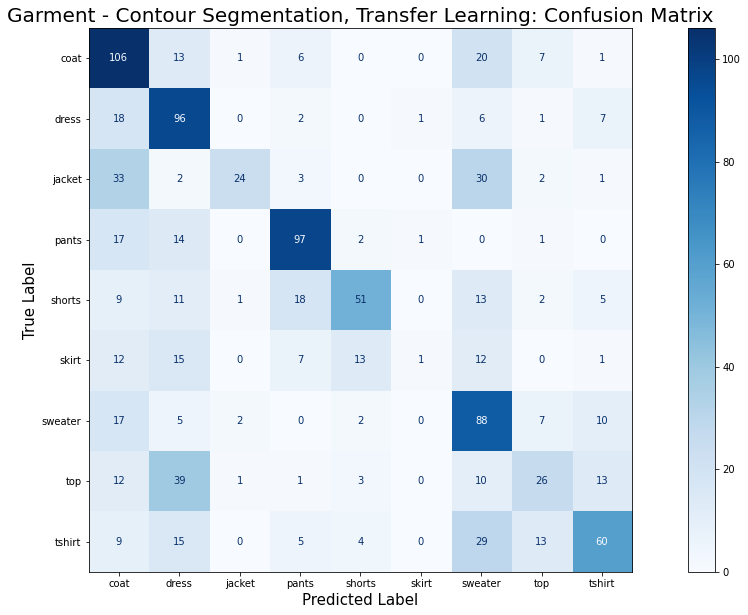

In [ ]:
model_vg_contour = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_contour,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_contour,
                  'garment_label','validation')

checkpoint_model_vg_contour = checkpoint('model_vg_contour')

history_vg_contour = model_vg_contour.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_contour,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_contour,'Garments- Contour Segmentation, Transfer Learning: Accuracy',
              'contour_garment_transfer')

plot_confusion_matrix('model_vg_contour',test_data,
                      'Garment - Contour Segmentation, Transfer Learning: Confusion Matrix',
                      'contour_garment_transfer')

The model fed the contour segmented images, when using transfer learning, performs considerably worse than the K-Means trained model, with its best validation accuracy of 52%. Areas of frequent misclassification, in addition to those that are frequent in the K-Means model are:

* Shorts/pants
* Sweater/jacket


## Sequential Pattern Model - Thresholding

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
Epoch 1/50
132/132 [==============================] - 1133s 9s/step - loss: 1.4452 - accuracy: 0.5645 - val_loss: 1.3943 - val_accuracy: 0.5664
Epoch 2/50
132/132 [==============================] - 58s 441ms/step - loss: 1.2302 - accuracy: 0.6107 - val_loss: 1.1649 - val_accuracy: 0.6537
Epoch 3/50
132/132 [==============================] - 59s 448ms/step - loss: 1.1027 - accuracy: 0.6536 - val_loss: 1.1183 - val_accuracy: 0.6546
Epoch 4/50
132/132 [==============================] - 58s 442ms/step - loss: 1.0651 - accuracy: 0.6619 - val_loss: 0.9328 - val_accuracy: 0.7106
Epoch 5/50
132/132 [==============================] - 58s 442ms/step - loss: 1.0150 - accuracy: 0.6757 - val_loss: 0.8877 - val_accuracy: 0.7343
Epoch 6/50
132/132 [==============================] - 60s 456ms/step - loss: 0.9857 - accuracy: 0.6989 - val_loss: 0.7859 - val_accuracy: 0.7533
E

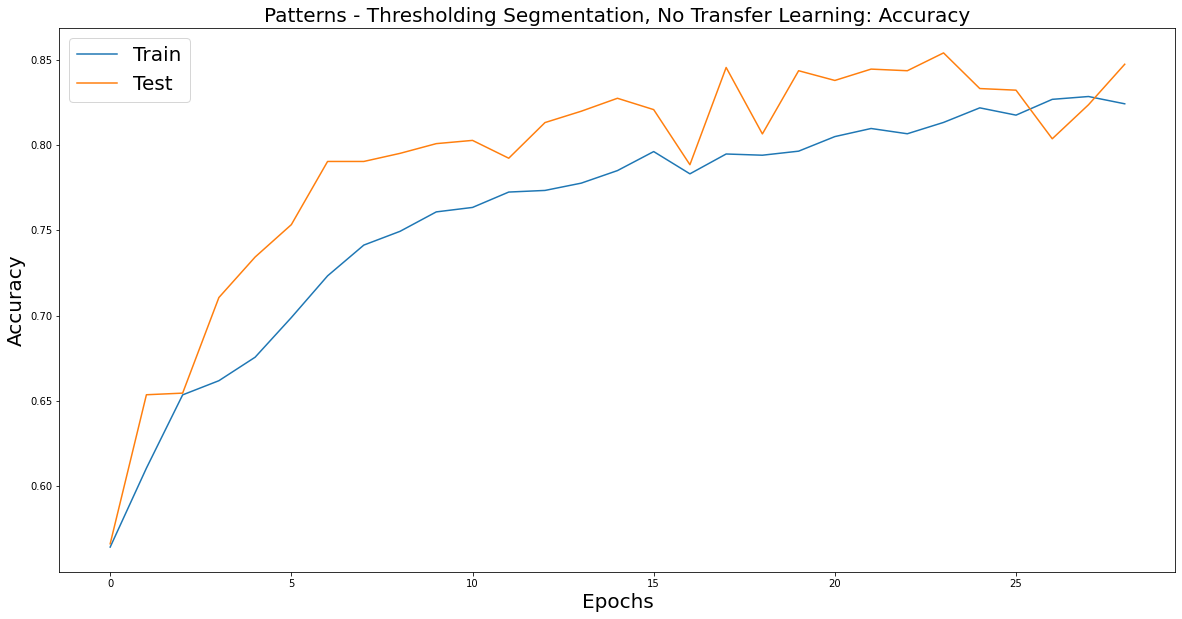

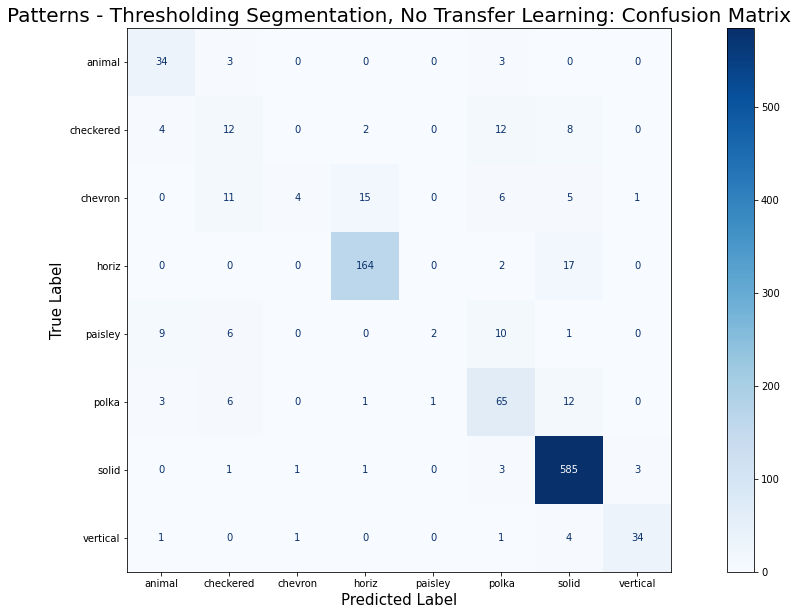

In [ ]:
model_sp_thresh = seq_model_function(classes = 8,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_thresh,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_thresh,
                  'pattern_label','validation')

checkpoint_model_sp_thresh = checkpoint('model_sp_thresh')

history_sp_thresh = model_sp_thresh.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_sp_thresh,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sp_thresh,'Patterns - Thresholding Segmentation, No Transfer Learning: Accuracy',
              'thresh_pattern_cnn')

plot_confusion_matrix('model_sp_thresh',test_data,
                      'Patterns - Thresholding Segmentation, No Transfer Learning: Confusion Matrix',
                      'thresh_pattern_cnn')

For thresholding segmented images, the models that did not use transfer learning again performed better. At ~85%, the highest validation accuracy for the thresholding model is higher than contour, but lower than K-Means.

Unlike the model that was fed contoured images, vertical stripes and animal prints were not notable areas of mislcassifications. The thresholding image model does misclassify paisley as checkered and polka, and misclassifies chevron and checkered at a similar rate to the contour model.

## Sequential Garment Model - Thresholding

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 1213s 9s/step - loss: 2.1682 - accuracy: 0.1482 - val_loss: 2.1443 - val_accuracy: 0.1973
Epoch 2/50
132/132 [==============================] - 57s 436ms/step - loss: 2.1394 - accuracy: 0.1726 - val_loss: 2.1030 - val_accuracy: 0.1793
Epoch 3/50
132/132 [==============================] - 58s 437ms/step - loss: 2.0922 - accuracy: 0.2091 - val_loss: 2.0113 - val_accuracy: 0.2647
Epoch 4/50
132/132 [==============================] - 56s 425ms/step - loss: 2.0555 - accuracy: 0.2229 - val_loss: 2.0112 - val_accuracy: 0.2372
Epoch 5/50
132/132 [==============================] - 59s 450ms/step - loss: 2.0110 - accuracy: 0.2544 - val_loss: 1.9811 - val_accuracy: 0.2799
Epoch 6/50
132/132 [==============================] - 58s 442ms/step - loss: 1.9556 - accuracy: 0.2741 - val_loss: 1.7886 - val_accuracy: 0.3501
E

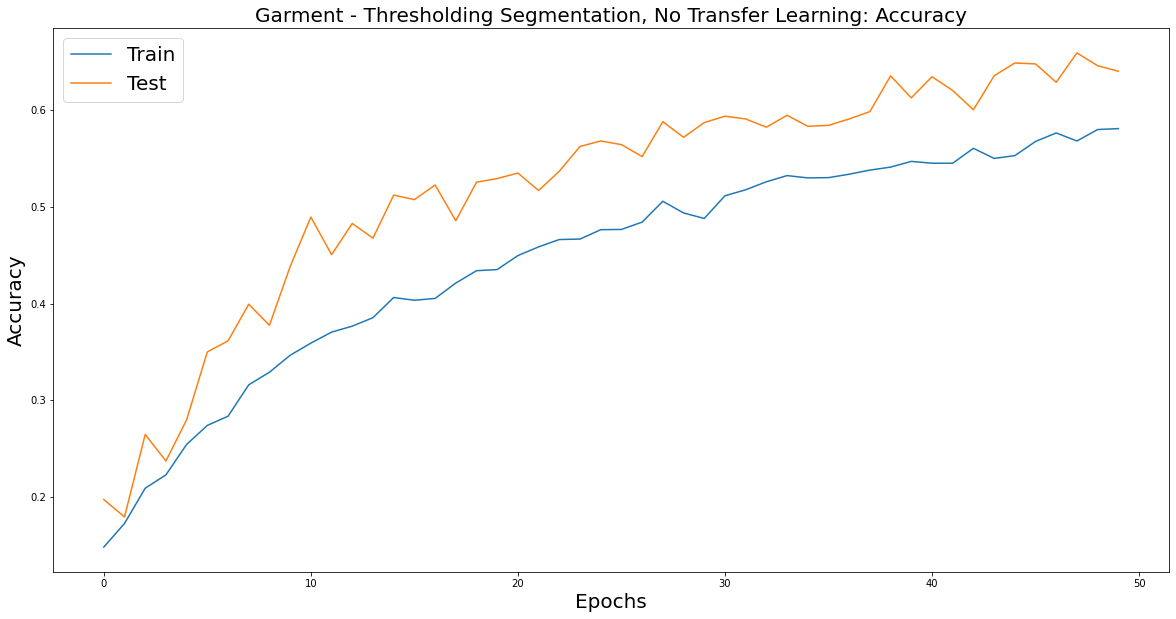

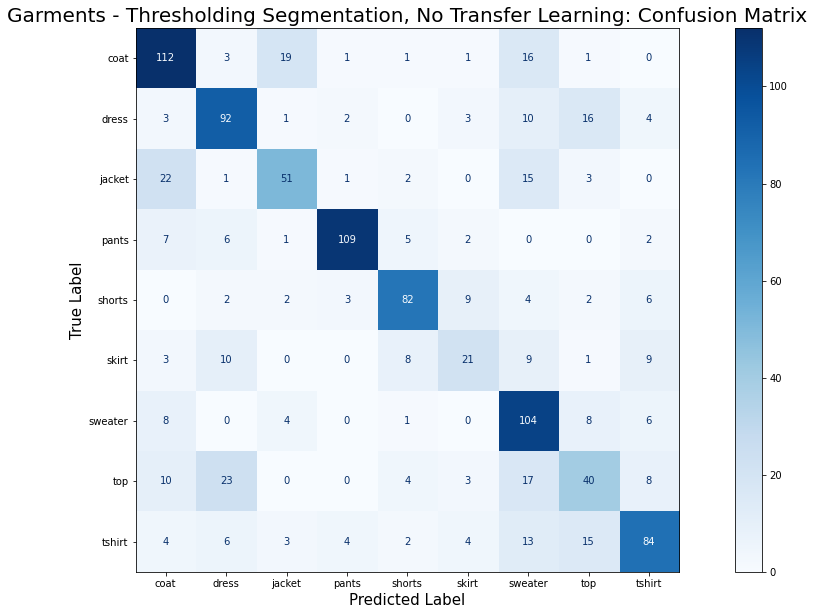

In [ ]:
model_sg_thresh = seq_model_function(classes = 9,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_thresh,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_thresh,
                  'garment_label','validation')

checkpoint_model_sg_thresh = checkpoint('model_sg_thresh')

history_sg_thresh = model_sg_thresh.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_sg_thresh,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sg_thresh,'Garment - Thresholding Segmentation, No Transfer Learning: Accuracy',
              'thresh_garment_cnn')

plot_confusion_matrix('model_sg_thresh',test_data,
                      'Garments - Thresholding Segmentation, No Transfer Learning: Confusion Matrix',
                      'thresh_garment_cnn')

The thresholding model, which did not use transfer learning, performed with a validation accuracy slightly higher than that of the K-Means segmentation.

Notable areas of misclassificationa are:
* Jacket/Coat
* Top/Sweater/Dress

In [ ]:
calculate_balanced_acc('model_sg_thresh',clothes_df,imseg_data_path_thresh,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.6309941175679386

## Transfer Learning Pattern Model - No Segmentation

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
Epoch 1/50
132/132 [==============================] - 1184s 9s/step - loss: 1.0689 - accuracy: 0.6790 - val_loss: 0.8208 - val_accuracy: 0.7419
Epoch 2/50
132/132 [==============================] - 69s 521ms/step - loss: 0.8794 - accuracy: 0.7323 - val_loss: 0.7177 - val_accuracy: 0.7780
Epoch 3/50
132/132 [==============================] - 67s 508ms/step - loss: 0.8165 - accuracy: 0.7440 - val_loss: 0.5826 - val_accuracy: 0.8065
Epoch 4/50
132/132 [==============================] - 62s 470ms/step - loss: 0.7485 - accuracy: 0.7627 - val_loss: 0.7140 - val_accuracy: 0.7533
Epoch 5/50
132/132 [==============================] - 69s 524ms/step - loss: 0.7478 - accuracy: 0.7660 - val_loss: 0.5895 - val_accuracy: 0.8188
Epoch 6/50
132/132 [==============================] - 62s 472ms/step - loss: 0.7103 - accuracy: 0.7805 - val_loss: 0.5999 - val_accuracy: 0.8046
E

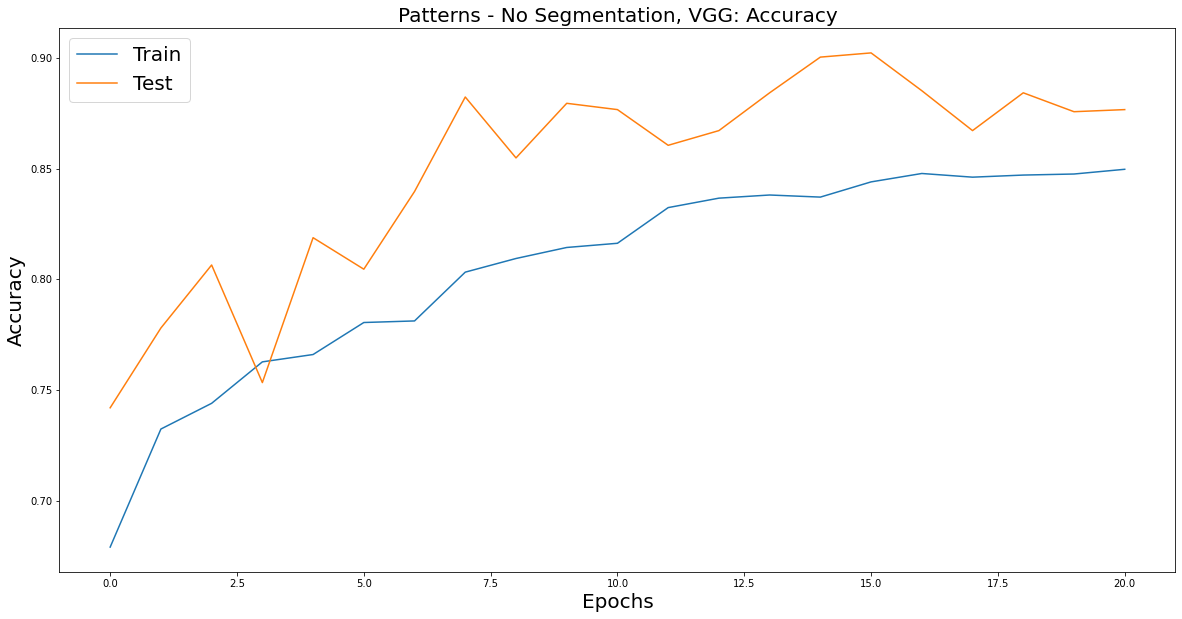

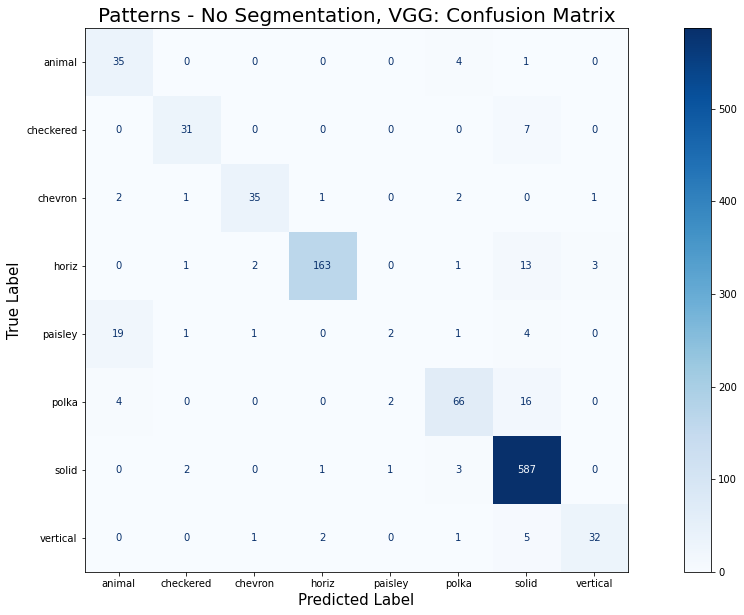

In [ ]:
model_vp_noseg = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'pattern_label','validation')

checkpoint_model_vp_noseg = checkpoint('model_vp_noseg')

history_vp_noseg = model_vp_noseg.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_noseg,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_noseg,'Patterns - No Segmentation, VGG: Accuracy',
              'noseg_pattern_transfer')

plot_confusion_matrix('model_vp_noseg',test_data,
                      'Patterns - No Segmentation, VGG: Confusion Matrix',
                      'noseg_pattern_transfer')

At ~90% validation accuracy, the model that used transfer learning and no image segmentation performed similarly strong to the K-Means segmented model, which achieved ~88% validation accuracy, but which had increasing accuracy as the early stop regularization ended the model.

Notable misclassification areas include polka, checkered and paisley.

In [ ]:
calculate_balanced_acc('model_vp_noseg',clothes_df,data_path,'pattern_label')

Found 1054 non-validated image filenames belonging to 8 classes.


0.7506206317566642

The K-Means model just barely surpassed the non-segmented model in terms of balanced accuracy.

## Transfer Learning Model, No Segmentation - Resampled Pattern Data

Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
Epoch 1/50
72/72 [==============================] - 52s 691ms/step - loss: 1.6103 - accuracy: 0.4333 - val_loss: 1.2389 - val_accuracy: 0.5965
Epoch 2/50
72/72 [==============================] - 49s 689ms/step - loss: 1.1864 - accuracy: 0.6057 - val_loss: 1.3769 - val_accuracy: 0.6435
Epoch 3/50
72/72 [==============================] - 48s 671ms/step - loss: 0.9662 - accuracy: 0.7008 - val_loss: 1.0632 - val_accuracy: 0.6939
Epoch 4/50
72/72 [==============================] - 49s 681ms/step - loss: 0.8959 - accuracy: 0.7256 - val_loss: 1.1373 - val_accuracy: 0.7130
Epoch 5/50
72/72 [==============================] - 48s 665ms/step - loss: 0.8901 - accuracy: 0.7247 - val_loss: 0.7863 - val_accuracy: 0.8052
Epoch 6/50
72/72 [==============================] - 42s 582ms/step - loss: 0.8268 - accuracy: 0.7538 - val_loss: 0.9353 - val_accuracy: 0.7687
Epoch 7/50
72

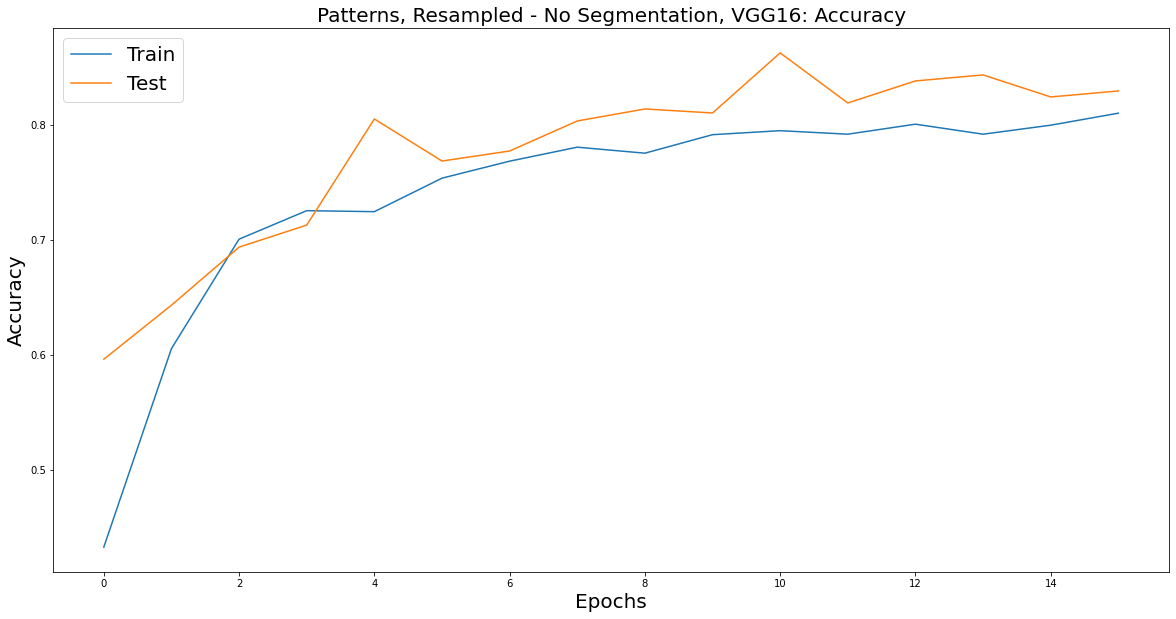

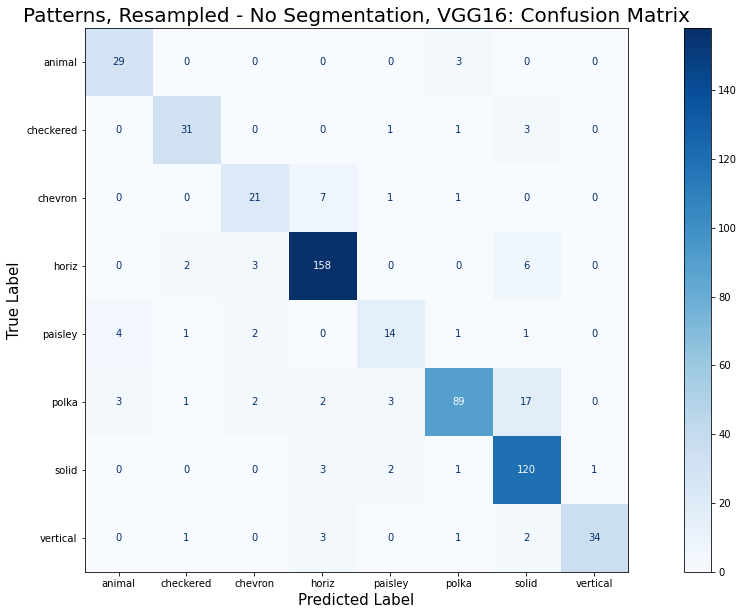

In [ ]:
model_vp_noseg_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,data_path,
                   'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                   'pattern_label','validation')

checkpoint_model_vp_noseg_r = checkpoint('model_vp_noseg_r')

history_vp_noseg_r = model_vp_noseg_r.fit(
     train_data,
     batch_size = 32,
     epochs=50,
     validation_data = test_data,
     callbacks = [checkpoint_model_vp_noseg_r,early_stop],
     validation_batch_size=32
 )

plot_accuracy(history_vp_noseg_r,'Patterns, Resampled - No Segmentation, VGG16: Accuracy',
              'noseg_pattern_transfer_r')

plot_confusion_matrix('model_vp_noseg_r',test_data,
                       'Patterns, Resampled - No Segmentation, VGG16: Confusion Matrix',
                       'noseg_pattern_transfer_r')

In [ ]:
calculate_balanced_acc('model_vp_noseg_r',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.798437187369585

The transfer learning model with no segmentation scored considerably better in balanced accuracy on the resampled dataset than the K-Means model, achieving a balanced accuracy score of 79.8% compared to the 75.5% for the K-Means model with 5 clusters. 

## Transfer Learning Garment Model - No Segmentation

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 1229s 9s/step - loss: 1.9663 - accuracy: 0.2850 - val_loss: 2.4517 - val_accuracy: 0.1528
Epoch 2/50
132/132 [==============================] - 65s 489ms/step - loss: 1.6762 - accuracy: 0.3862 - val_loss: 2.0040 - val_accuracy: 0.3586
Epoch 3/50
132/132 [==============================] - 66s 503ms/step - loss: 1.5568 - accuracy: 0.4298 - val_loss: 1.3265 - val_accuracy: 0.5398
Epoch 4/50
132/132 [==============================] - 59s 448ms/step - loss: 1.4718 - accuracy: 0.4642 - val_loss: 1.4254 - val_accuracy: 0.5228
Epoch 5/50
132/132 [==============================] - 64s 487ms/step - loss: 1.4221 - accuracy: 0.4910 - val_loss: 1.2491 - val_accuracy: 0.5636
Epoch 6/50
132/132 [==============================] - 66s 499ms/step - loss: 1.4001 - accuracy: 0.4867 - val_loss: 1.0082 - val_accuracy: 0.6271
E

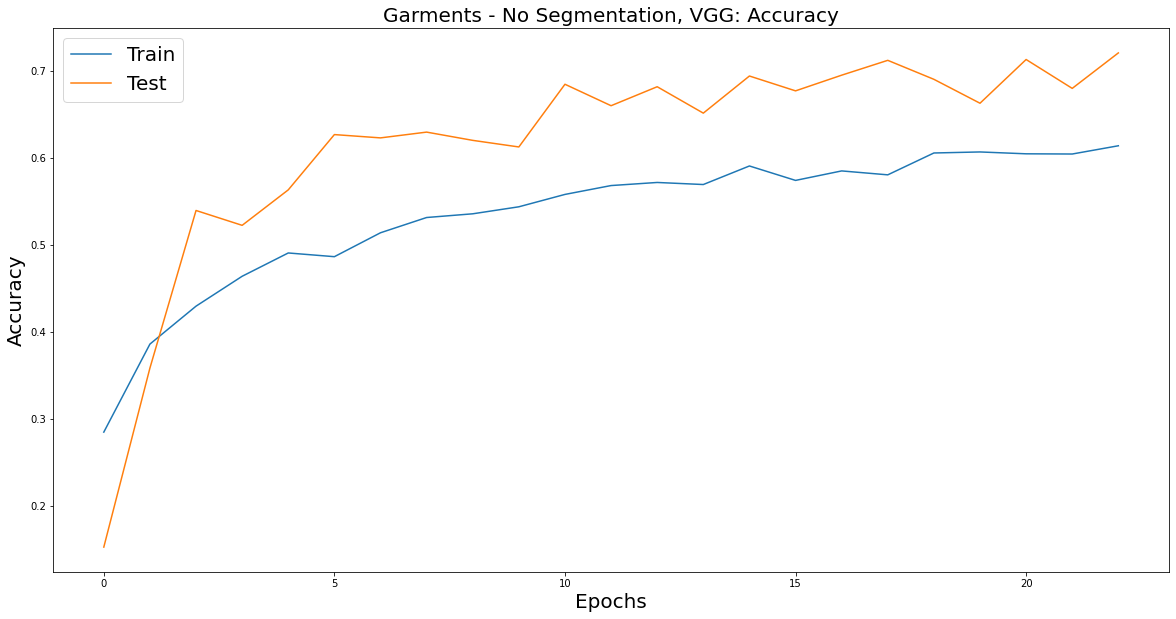

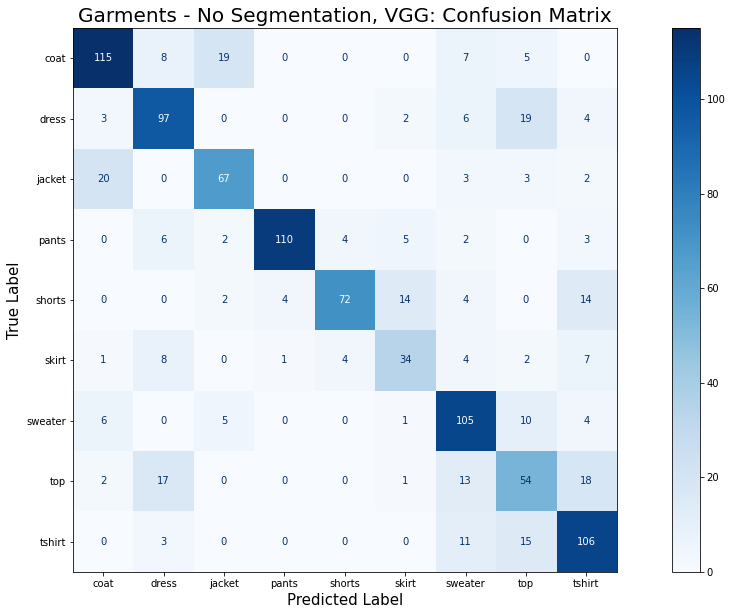

In [ ]:
model_vg_noseg = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_vg_noseg = checkpoint('model_vg_noseg')

history_vg_noseg = model_vg_noseg.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_noseg,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_noseg,'Garments - No Segmentation, VGG: Accuracy',
              'noseg_garment_transfer')

plot_confusion_matrix('model_vg_noseg',test_data,
                      'Garments - No Segmentation, VGG: Confusion Matrix',
                      'noseg_garment_transfer')

In [ ]:
calculate_balanced_acc('model_vg_noseg',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.7043030971113807

The model that uses no image segmentation and transfer learning performs best out of the garment classifiers. The epoch with the best validation accuracy achieved an accuracy of 72.11%, and a balanced accuracy of 70.4%. Notable areas of misclassification are:

* Coat/Jacket
* Dress/Top

## Transfer Learning Model, No Segmentation, Less Augmentation - Resampled Pattern Data

58900480/58889256 [==============================] - 0s 0us/step
Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
Epoch 1/50
72/72 [==============================] - 1132s 16s/step - loss: 1.5184 - accuracy: 0.4690 - val_loss: 1.4199 - val_accuracy: 0.5878
Epoch 2/50
72/72 [==============================] - 39s 547ms/step - loss: 1.0714 - accuracy: 0.6422 - val_loss: 4.1174 - val_accuracy: 0.4052
Epoch 3/50
72/72 [==============================] - 46s 638ms/step - loss: 0.9259 - accuracy: 0.7112 - val_loss: 1.3871 - val_accuracy: 0.5913
Epoch 4/50
72/72 [==============================] - 46s 644ms/step - loss: 0.8412 - accuracy: 0.7403 - val_loss: 1.1512 - val_accuracy: 0.6765
Epoch 5/50
72/72 [==============================] - 48s 668ms/step - loss: 0.7806 - accuracy: 0.7616 - val_loss: 0.7511 - val_accuracy: 0.7757
Epoch 6/50
72/72 [==============================] - 40s 549ms/step - loss: 0.7491 - accurac

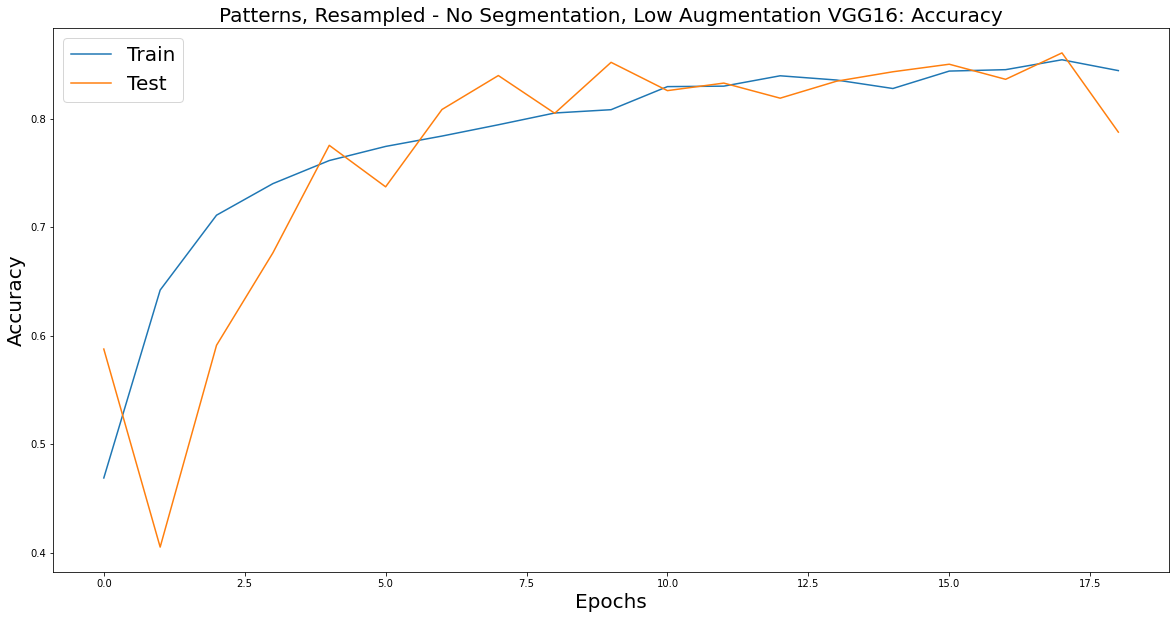

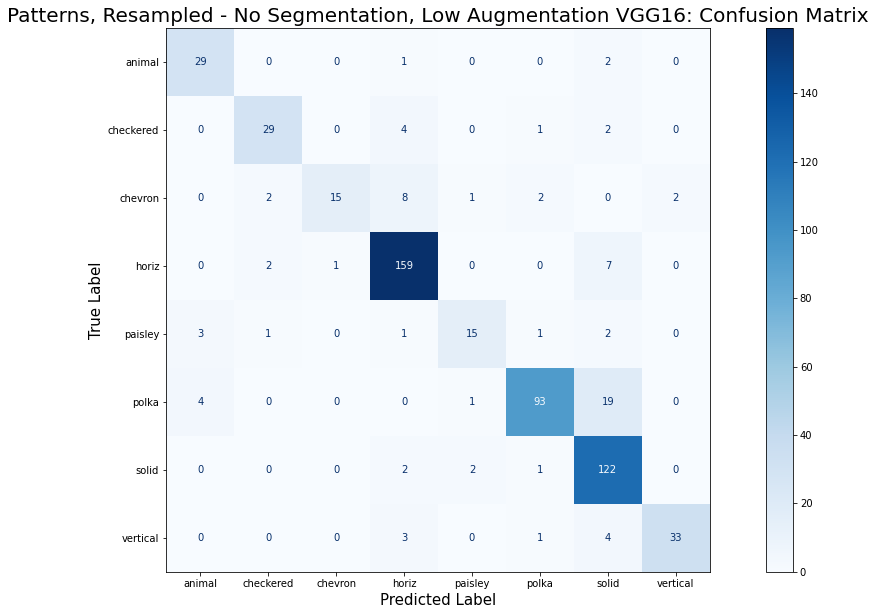

In [ ]:
model_vp_nsa_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(la_train_gen,resampled_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                  'pattern_label','validation')

checkpoint_model_vp_nsa_r = checkpoint('model_vp_nsa_r')

history_vp_nsa_r = model_vp_nsa_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_nsa_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_nsa_r,'Patterns, Resampled - No Segmentation, Low Augmentation VGG16: Accuracy',
              'nsa_pattern_transfer_r')

plot_confusion_matrix('model_vp_nsa_r',test_data,
                      'Patterns, Resampled - No Segmentation, Low Augmentation VGG16: Confusion Matrix',
                      'nsa_pattern_transfer_r')

In [ ]:
calculate_balanced_acc('model_vp_nsa_r',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7956484544847529

When fewer augmentations were applied to the non-segmented image data, and fed into the transfer learning model, performance relative to the model that was fed more augmented image data was fairly negilible. 

The confusion matrices are very similar. 

## Transfer Learning - Garment Model, No Segmentation, Less Augmentation 

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
Epoch 1/50
132/132 [==============================] - 1221s 9s/step - loss: 1.8249 - accuracy: 0.3385 - val_loss: 1.5088 - val_accuracy: 0.4326
Epoch 2/50
132/132 [==============================] - 72s 546ms/step - loss: 1.4326 - accuracy: 0.4891 - val_loss: 1.6347 - val_accuracy: 0.4165
Epoch 3/50
132/132 [==============================] - 80s 606ms/step - loss: 1.2886 - accuracy: 0.5436 - val_loss: 0.9692 - val_accuracy: 0.6679
Epoch 4/50
132/132 [==============================] - 74s 557ms/step - loss: 1.1649 - accuracy: 0.5920 - val_loss: 0.9951 - val_accuracy: 0.6414
Epoch 5/50
132/132 [==============================] - 82s 618ms/step - loss: 1.1432 - accuracy: 0.5982 - val_loss: 0.9569 - val_accuracy: 0.6926
Epoch 6/50
132/132 [==============================] - 80s 605ms/step - loss: 1.1062 - accuracy: 0.6211 - val_loss: 0.8256 - val_accuracy: 0.7173
E

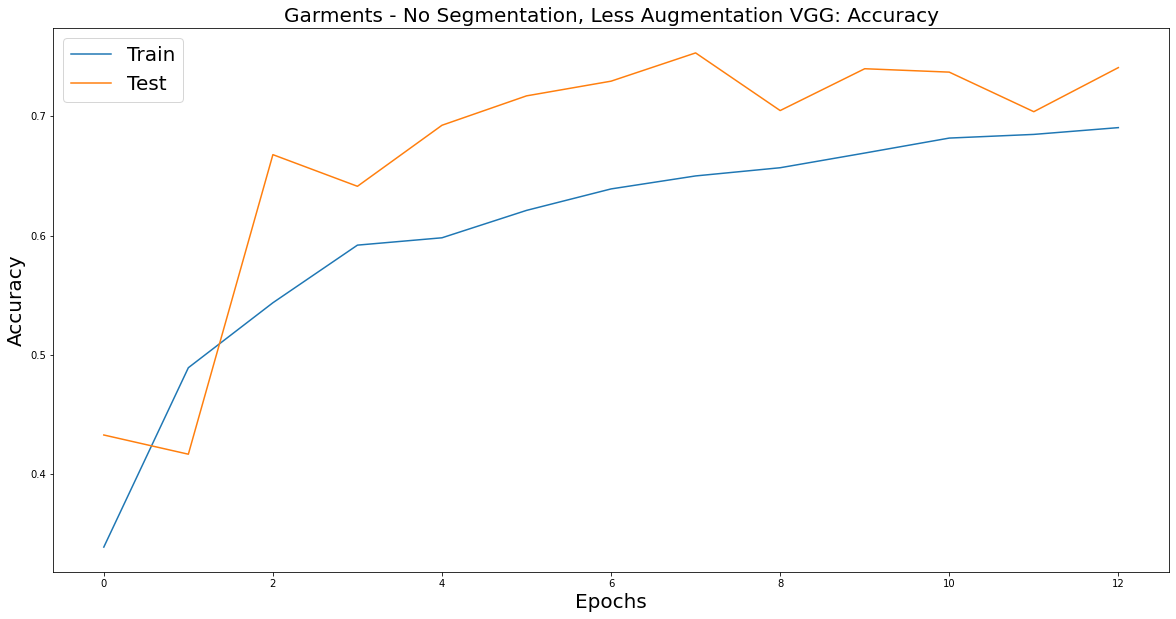

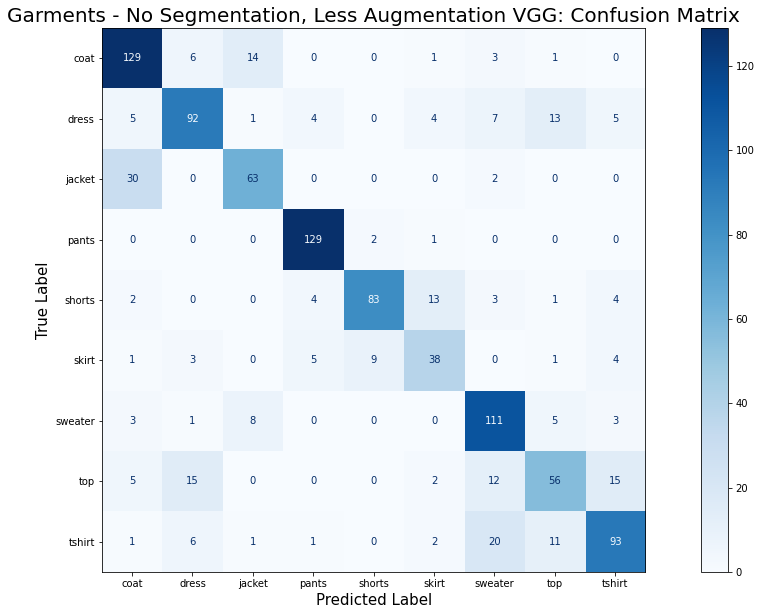

In [ ]:
model_vg_nsa = model_function(classes = 9,alr=.01)

train_data = tensor_data(la_train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_vg_nsa = checkpoint('model_vg_nsa')

history_vg_nsa = model_vg_nsa.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_nsa,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_nsa,'Garments - No Segmentation, Less Augmentation VGG: Accuracy',
              'nsa_garment_transfer')

plot_confusion_matrix('model_vg_nsa',test_data,
                      'Garments - No Segmentation, Less Augmentation VGG: Confusion Matrix',
                      'nsa_garment_transfer')

In [ ]:
calculate_balanced_acc('model_vg_nsa',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.7363810863024891

A model with less augmentation, using no segmentation, had the best balanced accuracy score on the garment data, with a score of 73.63%.